# TensorFlow deep NN
#### A high-level tutorial into Deep Learning using MNIST data and TensorFlow library.
by [@kakauandme](https://twitter.com/KaKaUandME) and [@thekoshkina](https://twitter.com/thekoshkina)

Accuracy: 0.99

**Prerequisites:** fundamental coding skills, a bit of linear algebra, especially matrix operations and perhaps understanding how images are stored in computer memory. To start with machine learning, we suggest [coursera course](https://www.coursera.org/learn/machine-learning) by Andrew Ng.


Note: 

*Feel free to fork and adjust* CONSTANTS *to tweak network behaviour and explore how it changes algorithm performance and accuracy. Besides **TensorFlow graph** section can also be modified for learning purposes.*

*It is highly recommended printing every variable that isn’t 100% clear for you. Also, [tensorboard](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html) can be used on a local environment for visualisation and debugging.*
## Libraries and settings

In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 2500        
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

## Data preparation
To start, we read provided data. The *train.csv* file contains 42000 rows and 785 columns. Each row represents an image of a handwritten digit and a label with the value of this digit.

In [4]:
# read training data from CSV file 
data = pd.read_csv('../input/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

Every image is a "stretched" array of pixel values.

In [5]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In this case it's 784 pixels => 28 * 28px

In [6]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


To output one of the images, we reshape this long string of pixels into a 2-dimensional array, which is basically a grayscale image.

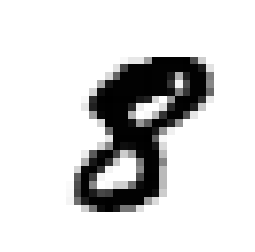

In [7]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# output image     
display(images[IMAGE_TO_DISPLAY])

The corresponding labels are numbers between 0 and 9, describing which digit a given image is of.

In [ ]:
labels_flat = data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

In this case, there are ten different digits/labels/classes.

In [ ]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

For most classification problems "one-hot vectors" are used. A one-hot vector is a vector that contains a single element equal to 1 and the rest of the elements equal to 0. In this case, the *nth* digit is represented as a zero vector with 1 in the *nth* position.

In [ ]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

Lastly we set aside data for validation. It's essential in machine learning to have a separate dataset which doesn't take part in the training and is used to make sure that what we've learned can actually be generalised.

In [ ]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

*Data is ready. The neural network structure is next.*
## TensorFlow graph
TensorFlow does its heavy lifting outside Python. Therefore, instead of running every single operation independently, TensorFlow allows users to build a whole graph of interacting operations and then runs the workflow in a separate process at once.
#### Helper functions
For this NN model, a lot of weights and biases are created. Generally, weights should be initialised with a small amount of noise for symmetry breaking, and to prevent 0 gradients. 

Since we are using [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) neurones (ones that contain rectifier function *f(x)=max(0,x)*), it is also good practice to initialise them with a slightly positive initial bias to avoid "dead neurones".

In [ ]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

For this problem we use zero padded [convolutions](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer) so that the output is the same size as the input. Stride/step in this case is equal to 1.

In general, convolution layer is used to get the features of the data.  In the case of digit recognition - a shape of each digit.  It uses learnable kernels/filters each of which corresponds to one particular shape pattern. The number of the filter can differ for other problems.

In [ ]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

[Pooling](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer) is plain max pooling over 2x2 blocks.

Pooling is used for downsampling of the data. 2x2 max-pooling splits the image into square 2-pixel blocks and only keeps maximum value for each of those blocks. 

In [ ]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

*We'll get back to convolutions and pooling in more detail below.*

The good thing about neural networks that any NN can be used as a layer in a large multilayer NN meaning that output of one can be used as input for another. This sequential approach can create very sophisticated NN with multiple layers. They are also called Deep Neural Networks.

In this case, we use two convolution layers with pooling in between them, then densely connected layer followed by dropout and lastly readout layer.

In [ ]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

The first layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

To apply the layer, we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image width and height, and the final dimension - to the number of colour channels.

After the convolution, pooling reduces the size of the output from 28x28 to 14x14.

In [ ]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

The second layer has 64 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 32, 64]. The first two dimensions are the patch size, the next is the number of input channels (32 channels correspond to 32 featured that we got from previous convolutional layer), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

Because the image is down-sampled by pooling to 14x14 size second convolutional layer picks up more general characteristics of the images. Filters cover more space of the picture. Therefore, it is adjusted for more generic features while the first layer finds smaller details.

In [ ]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Now that the image size is reduced to 7x7, we add a [fully-connected layer](https://en.wikipedia.org/wiki/Convolutional_neural_network#Fully_Connected_layer) with 1024 neurones to allow processing on the entire image (each of the neurons of the fully connected layer is connected to all the activations/outpus of the previous layer)

In [ ]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

To prevent overfitting, we  apply [dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) before the readout layer.

Dropout removes some nodes from the network at each training stage. Each of the nodes is either kept in the network with probability *keep_prob* or dropped with probability *1 - keep_prob*. After the training stage is over the nodes are returned to the NN with their original weights.

In [ ]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally, we add a softmax layer, the same one if we use just a  simple [softmax regression](https://en.wikipedia.org/wiki/Softmax_function).

In [ ]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

To evaluate network performance we use [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) and to minimise it [ADAM optimiser](http://arxiv.org/pdf/1412.6980v8.pdf) is used. 

ADAM optimiser is a gradient based optimization algorithm, based on adaptive estimates, it's more sophisticated than steepest gradient descent and is well suited for problems with large data or many parameters.

In [ ]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To predict values from test data, highest probability is picked from "one-hot vector" indicating that chances of  an image being one of the digits are highest.

In [ ]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

*Finally neural network structure is defined and TensorFlow graph is ready for training.*
## Train, validate and predict
#### Helper functions

Ideally, we should use all data for every step of the training, but that's expensive. So, instead, we use small "batches" of random data. 

This method is called [stochastic training](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). It is cheaper, faster and gives much of the same result.

In [ ]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

Now when all operations for every variable are defined in TensorFlow graph all computations will be performed outside Python environment.

In [ ]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Each step of the loop, we get a "batch" of data points from the training set and feed it to the graph to replace the placeholders.  In this case, it's:  *x, y* and *dropout.*

Also, once in a while, we check training accuracy on an upcoming "batch".

On the local environment, we recommend [saving training progress](https://www.tensorflow.org/versions/master/api_docs/python/state_ops.html#Saver), so it can be recovered for further training, debugging or evaluation.

In [ ]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

After training is done, it's good to check accuracy on data that wasn't used in training.

In [ ]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

When, we're happy with the outcome, we read test data from *test.csv* and predict labels for provided images.

Test data contains only images and labels are missing. Otherwise, the structure is similar to training data.

Predicted labels are stored into CSV file for future submission.

In [ ]:
# read test data from CSV file 
test_images = pd.read_csv('../input/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

## Appendix
As it was mentioned before, it is good to output some variables for a better understanding of the process. 

Here we pull an output of the first convolution layer from TensorFlow graph. 32 features are transformed into an image grid, and it's quite interesting to see how filters picked by NN outline characteristics of different digits.

In [ ]:
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )

In [ ]:
sess.close()

## Reference
- [Deep MNIST for Experts](https://www.tensorflow.org/versions/master/tutorials/mnist/pros/index.html#deep-mnist-for-experts)
- [A Convolutional Network implementation example using TensorFlow library](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3%20-%20Neural%20Networks/convolutional_network.ipynb)
- [Digit recognizer in Python using CNN](https://www.kaggle.com/kobakhit/digit-recognizer/digit-recognizer-in-python-using-cnn)
- [Deep Learning in a Nutshell: Core Concepts](http://devblogs.nvidia.com/parallelforall/deep-learning-nutshell-core-concepts/)